In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)
max_training_query_size = 4
max_test_query_size = 9
desirable_test_test_onto_size = 400
desirable_train_test_onto_size = 1200
desirable_train_onto_size = 1600
rng = np.random.default_rng(seed)
random.seed(seed)

In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, max_training_query_size)

In [5]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_te_tr[2]))
print(len(data_te_vl[2]))
print(len(y_te_te))

54490
25510

27136
6426
6438


In [6]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [7]:
for i, onto in enumerate(test_onto):
    fact = Reasoner.from_onto(onto, timeout=None)
    queries, answers = make_dataset(onto, fact, rng, desirable_test_test_onto_size - idx_te_te.count(i), max_training_query_size + 1 ,max_test_query_size)
    X_te_te.extend(queries)
    idx_te_te.extend(len(queries)*[i])
    y_te_te.extend(answers)


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


In [8]:
for i, onto in enumerate(train_onto):
    fact = Reasoner.from_onto(onto, timeout=None)
    queries, answers = make_dataset(onto, fact, rng, desirable_train_onto_size - data_tr[0].count(i), 3, max_training_query_size)
    data_tr[1].extend(queries)
    data_tr[0].extend(len(queries)*[i])
    data_tr[2].extend(answers)

In [9]:
data_te_tr = reduce_dataset(data_te_tr, len(test_onto), desirable_train_test_onto_size, [idx_te_te, X_te_te, y_te_te])

In [10]:
print(len(data_tr[2]))
print(len(data_vl[2]))
print()
print(len(data_te_tr[2]))
print(len(data_te_vl[2]))
print(len(y_te_te))

64000
25510

24000
6426
8000


In [11]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21975
0.21258330066640532

0.20783333333333334
0.207749766573296
0.212


In [12]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
    batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 0.7204 | val loss 0.7206 | acc 0.2125 | f1 0.3505 | prec 0.2125 | recall 0.9994 | roc auc 0.5276 | pr auc 0.2303 | elapsed 21.04s
train epoch 01/15 | batch 2001/2000 | loss 0.5806 | val loss 0.4968 | acc 0.7982 | f1 0.1121 | prec 0.8690 | recall 0.0599 | roc auc 0.6140 | pr auc 0.3437 | elapsed 42.09s
train epoch 02/15 | batch 2001/2000 | loss 0.4263 | val loss 0.4743 | acc 0.8049 | f1 0.3042 | prec 0.6285 | recall 0.2006 | roc auc 0.7275 | pr auc 0.4758 | elapsed 43.06s
train epoch 03/15 | batch 2001/2000 | loss 0.3107 | val loss 0.4866 | acc 0.8204 | f1 0.4599 | prec 0.6374 | recall 0.3598 | roc auc 0.7547 | pr auc 0.5492 | elapsed 50.51s
train epoch 04/15 | batch 2001/2000 | loss 0.2375 | val loss 0.5052 | acc 0.8145 | f1 0.4801 | prec 0.5939 | recall 0.4029 | roc auc 0.7615 | pr auc 0.5756 | elapsed 48.88s
train epoch 05/15 | batch 2001/2000 | loss 0.1965 |

In [13]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 751/750 | loss 1.3026 | val loss 1.3504 | acc 0.6055 | f1 0.3677 | prec 0.2756 | recall 0.5521 | roc auc 0.6352 | pr auc 0.3806 | elapsed 8.13s
train epoch 01/10 | batch 751/750 | loss 1.1496 | val loss 1.2125 | acc 0.6307 | f1 0.3786 | prec 0.2911 | recall 0.5416 | roc auc 0.6532 | pr auc 0.3986 | elapsed 12.72s
train epoch 02/10 | batch 751/750 | loss 0.8484 | val loss 1.1013 | acc 0.6603 | f1 0.3978 | prec 0.3148 | recall 0.5401 | roc auc 0.6700 | pr auc 0.4165 | elapsed 13.42s
train epoch 03/10 | batch 751/750 | loss 0.6196 | val loss 1.0170 | acc 0.6816 | f1 0.4111 | prec 0.3338 | recall 0.5348 | roc auc 0.6852 | pr auc 0.4344 | elapsed 12.95s
train epoch 04/10 | batch 751/750 | loss 0.4583 | val loss 0.9557 | acc 0.7034 | f1 0.4321 | prec 0.3587 | recall 0.5431 | roc auc 0.6983 | pr auc 0.4509 | elapsed 12.52s
train epoch 05/10 | batch 751/750 | loss 0.3484 | val loss 0.9113 | acc 0.7208 | f1 0.4483 | prec 0.3803 | recall 0.5461 | roc au

In [14]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240729T204336


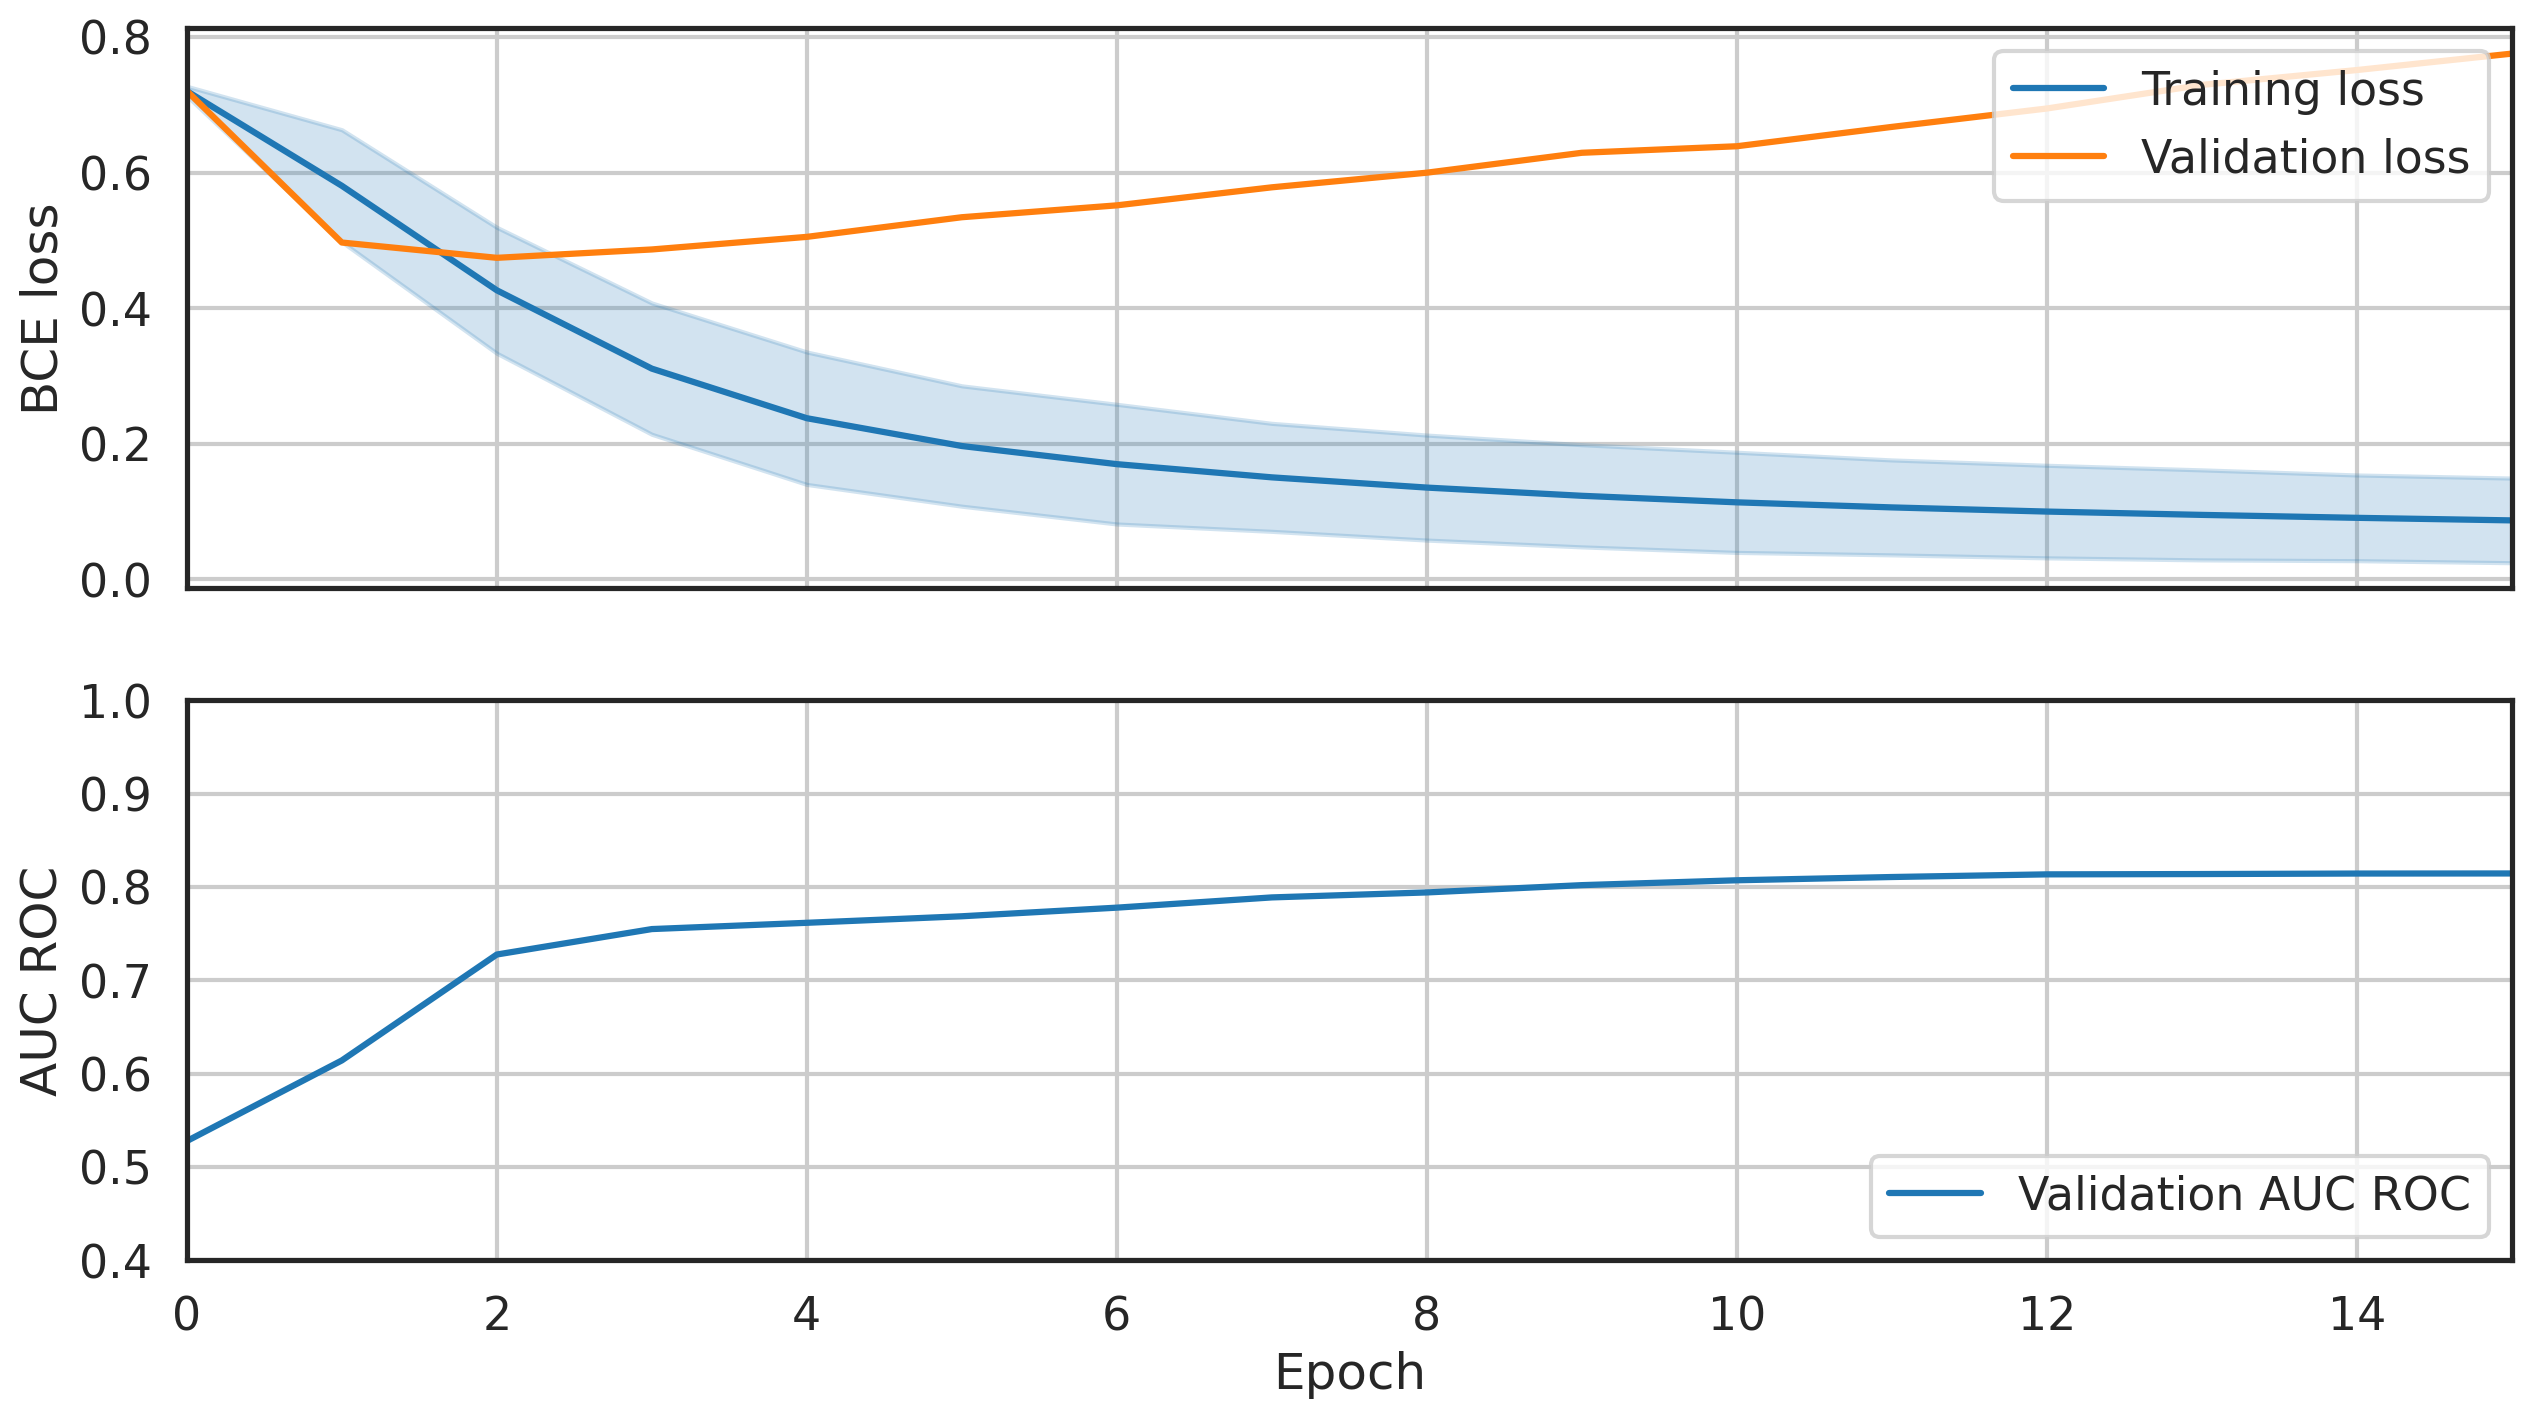

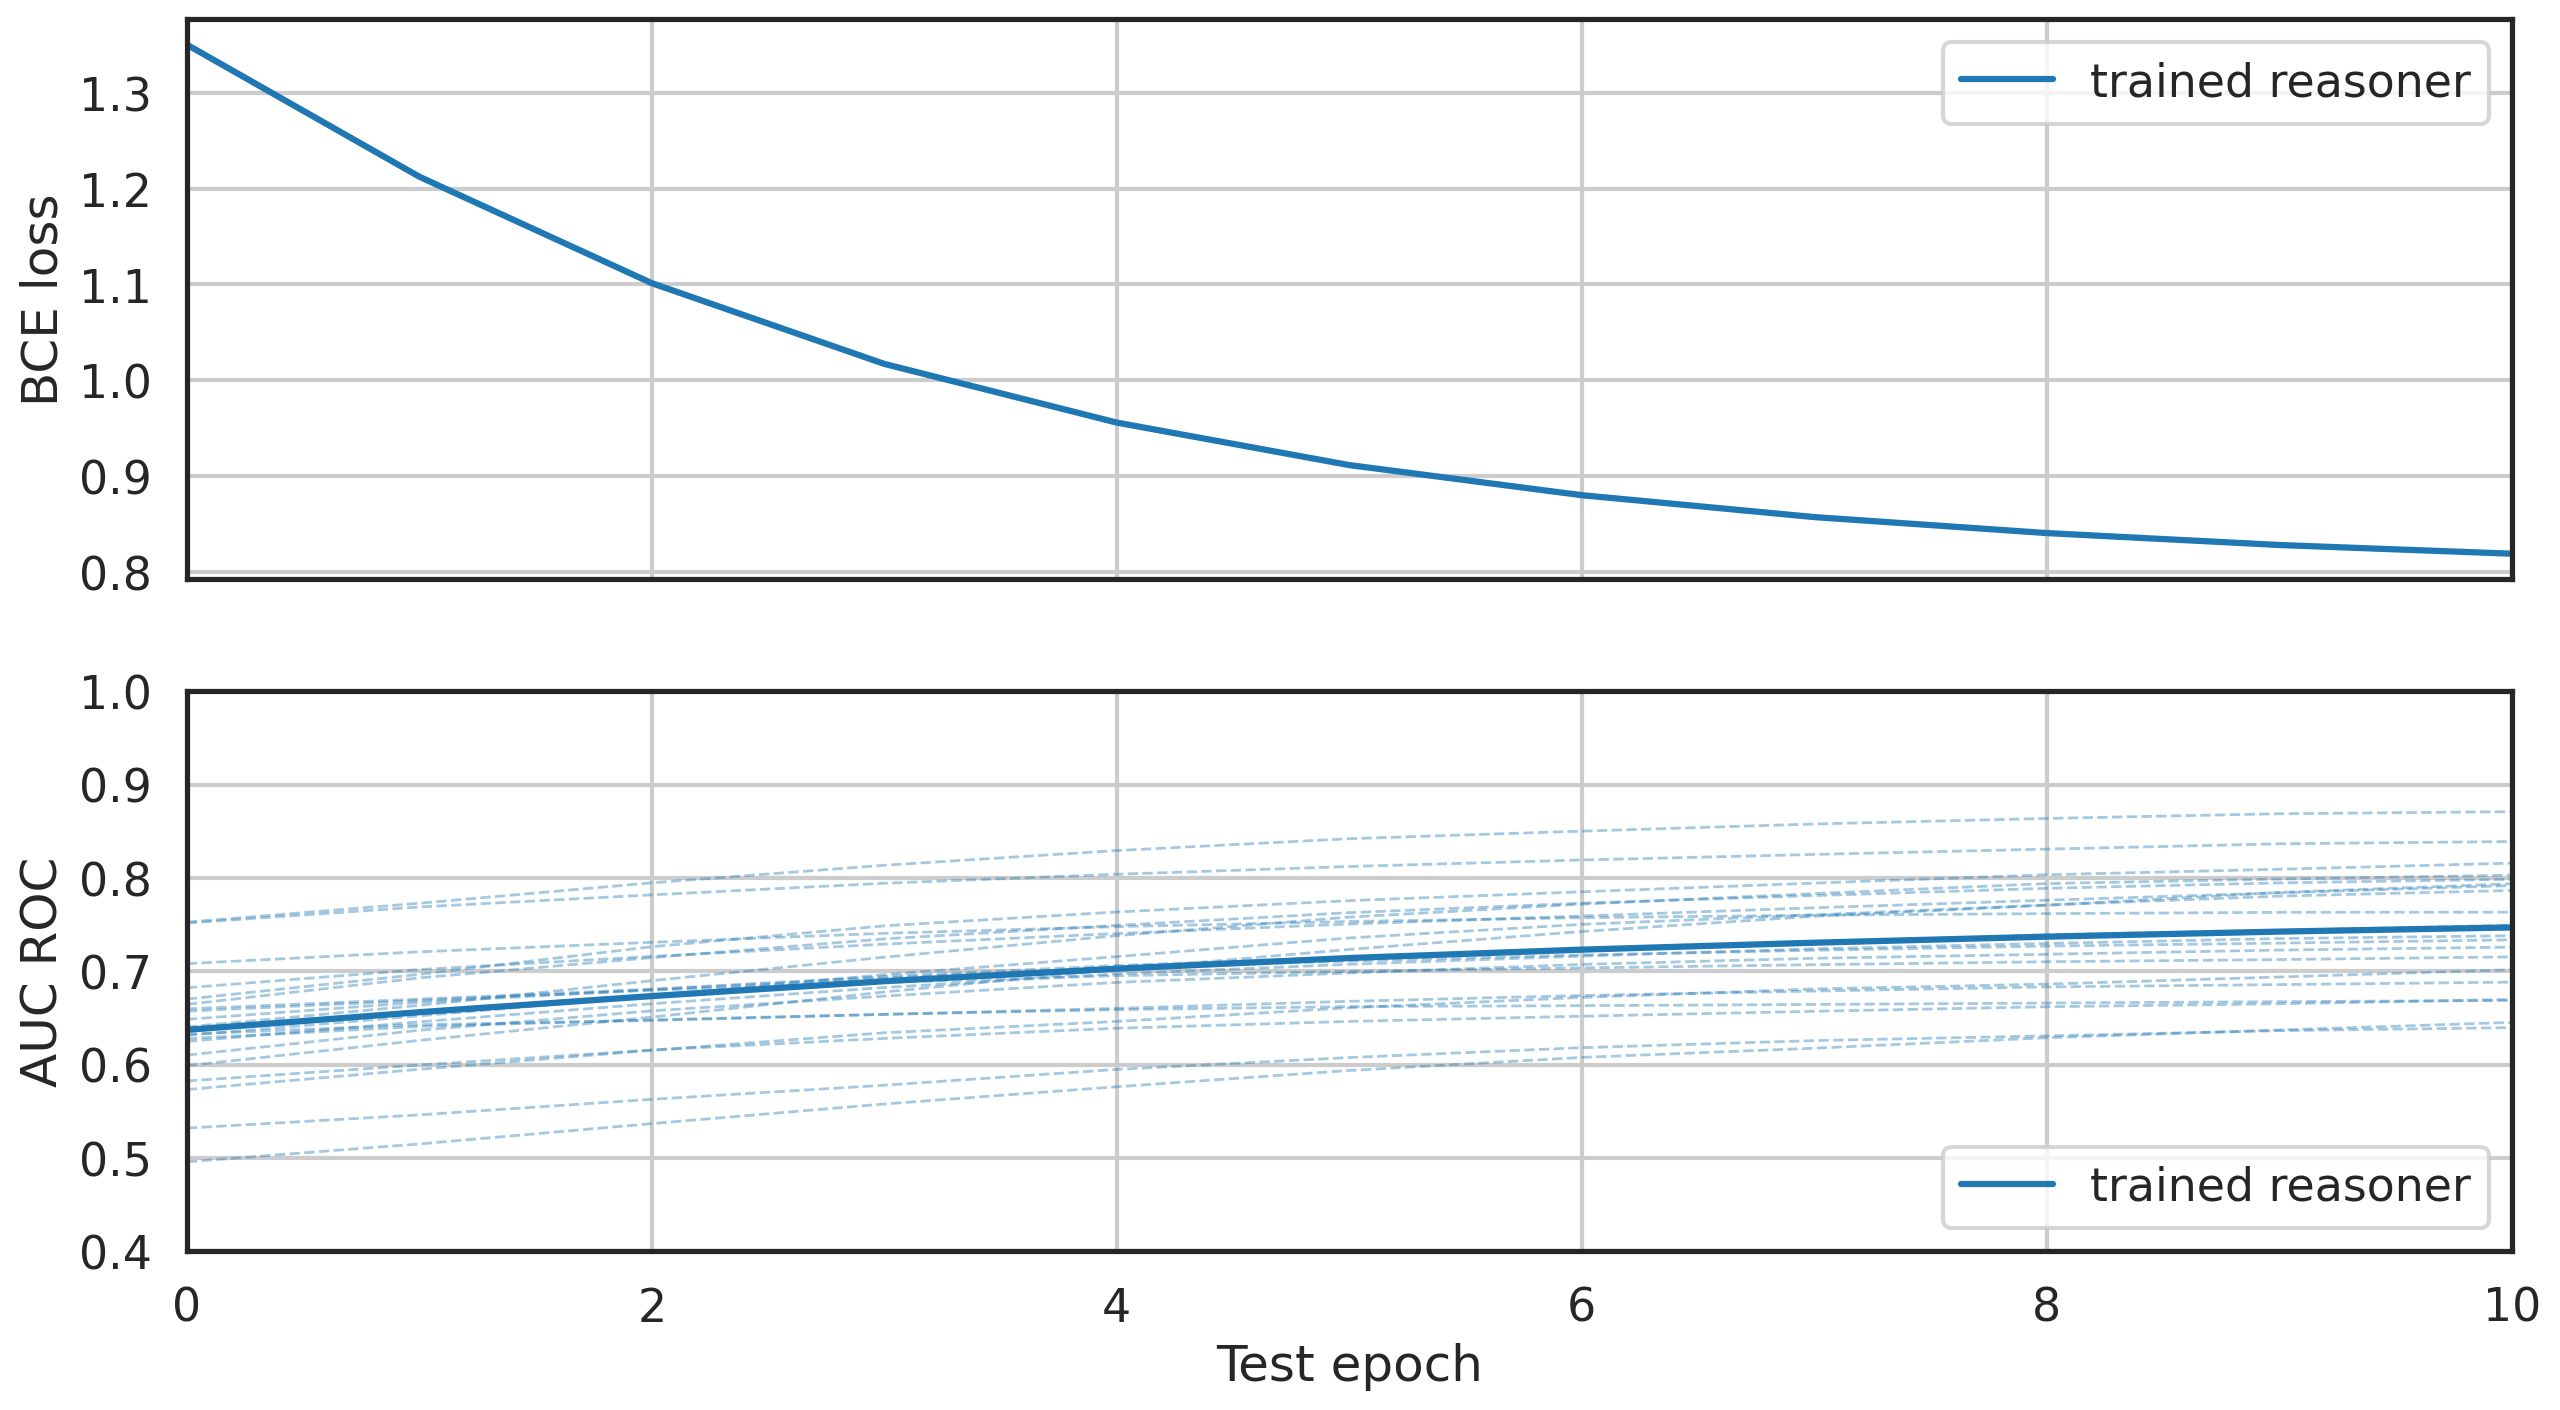

             mean       std     micro
acc      0.777125  0.049159  0.777125
prec     0.497494  0.112761  0.479870
recall   0.617433  0.100722  0.611439
f1       0.537841  0.059047  0.537724
auc_roc  0.779635  0.053873  0.773220
auc_pr   0.597116  0.090383  0.571650


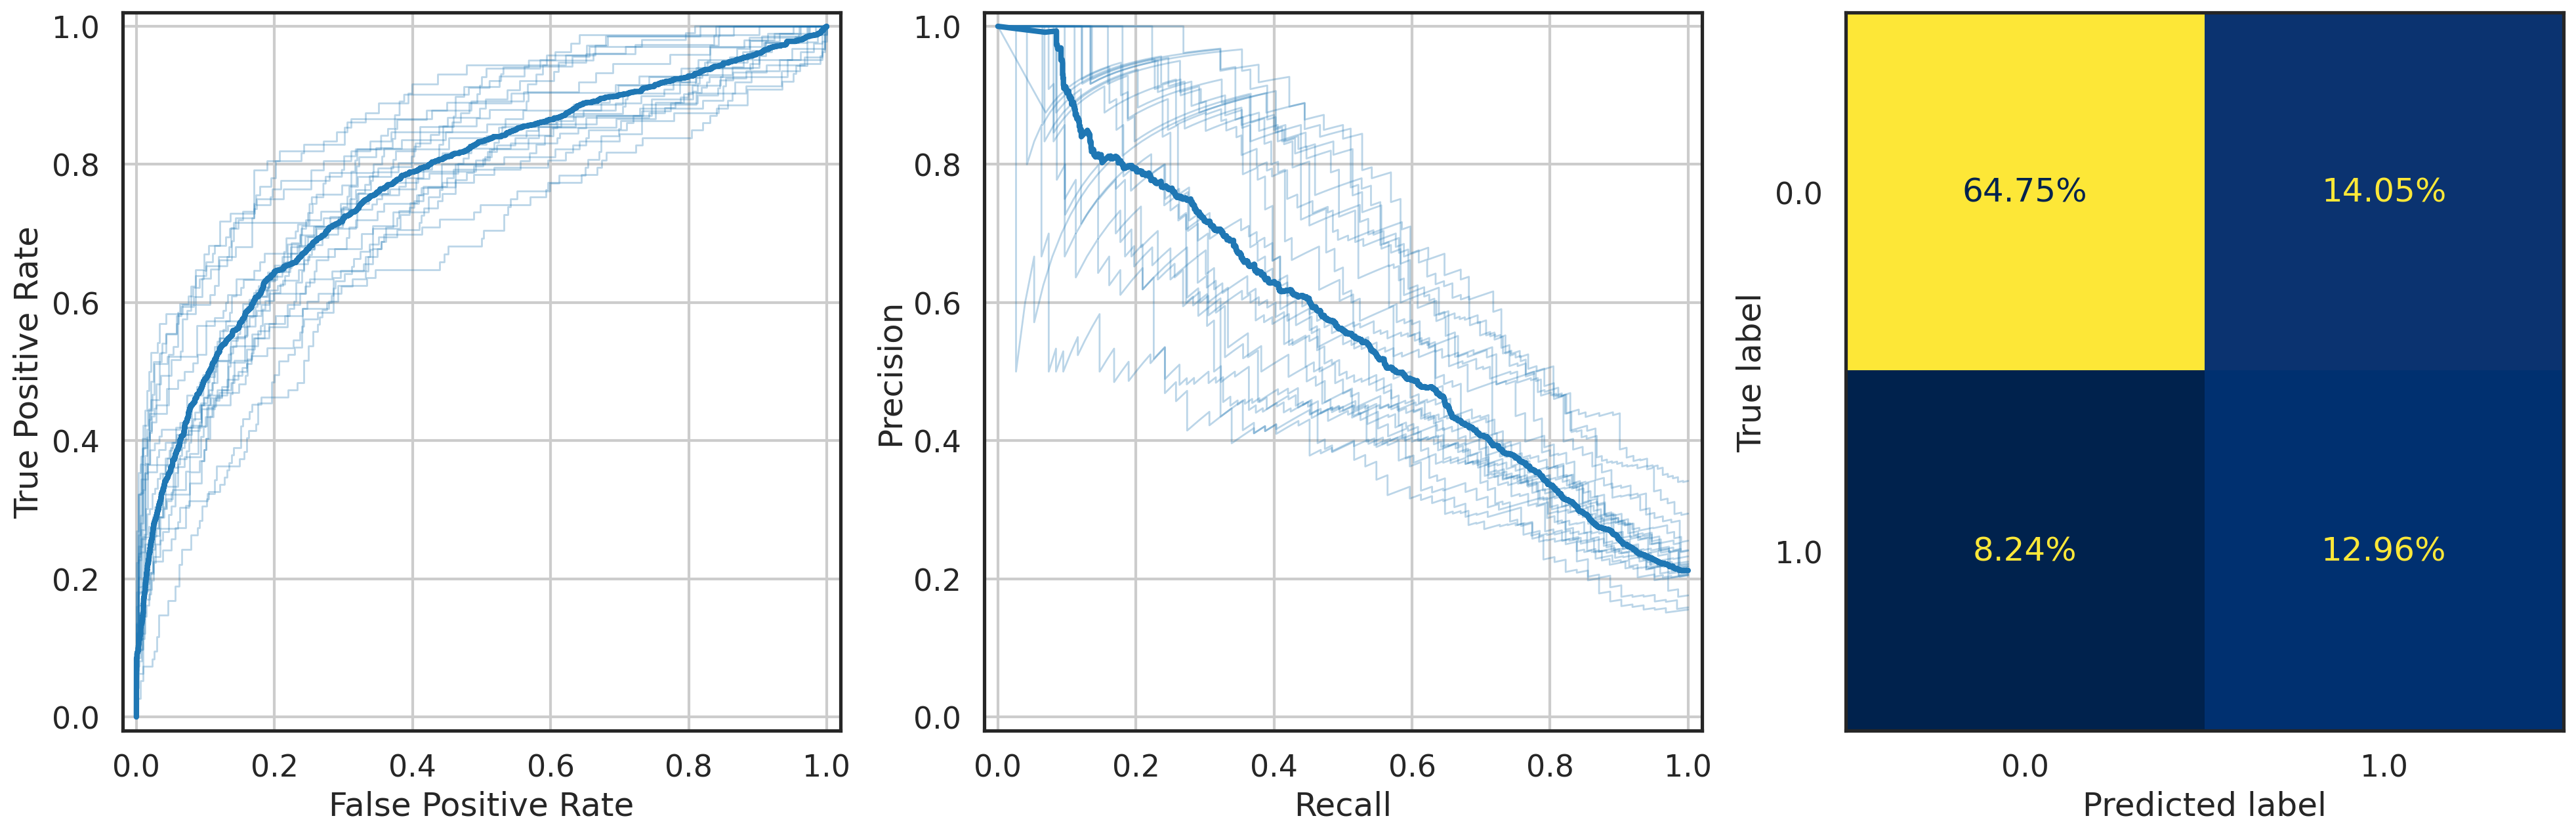

In [15]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [16]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [17]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [18]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.277143
  Std Dev Loss: 0.035347
  Mean Diff: 0.628881
  Std Dev Diff: 0.101965

Duality of Top and Bottom:
  Mean Loss: 0.363924
  Std Dev Loss: 0.000000
  Mean Diff: 0.561400
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.131645
  Std Dev Loss: 0.036043
  Mean Diff: 0.320505
  Std Dev Diff: 0.092946

Associativity:
  Mean Loss: 0.047635
  Std Dev Loss: 0.028948
  Mean Diff: 0.095775
  Std Dev Diff: 0.042249

Commutativity:
  Mean Loss: 0.037591
  Std Dev Loss: 0.012896
  Mean Diff: 0.088069
  Std Dev Diff: 0.031600

Contradiction:
  Mean Loss: 0.410053
  Std Dev Loss: 0.015752
  Mean Diff: 0.855600
  Std Dev Diff: 0.048604

Identity with Top:
  Mean Loss: 0.168330
  Std Dev Loss: 0.037267
  Mean Diff: 0.464735
  Std Dev Diff: 0.120567

Absorption by Bottom:
  Mean Loss: 0.576181
  Std Dev Loss: 0.023302
  Mean Diff: 1.222185
  Std Dev Diff: 0.061707

Top Concept Subsumption:
  Mean Loss: 0.000697
  Std Dev Loss: 0.000728
  Mean Diff: N/A
  Std De